In [31]:
#coding: utf-8

import warnings

import os
import sys 
import wave
import time
import librosa
import numpy as np
from utils import *
import matplotlib.pyplot as plt
from StringIO import StringIO
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter

%pylab inline

# sudo pip install librosa
# ubuntu: sudo apt-get install libav-tools
# OSX   : brew install libav OMP_NUM_THREADS=2

Populating the interactive namespace from numpy and matplotlib


# Get the Data

Датасет для контеста помещен вот здесь: https://yadi.sk/d/3jmeVCfSwTKgm (внимание! файл весит 3,5 Гб)


Он распаковывается в папку "musicdata". Все пути в этом ноутбуке будут относительно этой папки: "./musicdata/\*". 

Вы можете изменить базовый путь, как вам удобно.

In [2]:
BP = "./musicdata/"

# Just a Sound

Для начала попробуем поработать со звуком - послушайте любой трек, постройте график сырых данных и спектрограмму.

Что-то случилось с librosa и он отказывается читать файл. После первого запуска было норм, но потом сломалось

In [3]:
import IPython
from IPython import display

def Audio(url):
    html = "<center><audio controls><source src='{}' type=\"audio/wav\"></audio controls></center>".format(url)
    return display.HTML(html)

In [4]:
sound_file = os.path.join(BP, 'audiosamples', 'short_206377.wav')
#sound_file = './short_206377.wav'
y, sr = librosa.load(sound_file)

Audio(url=sound_file)

In [5]:
Audio(url=sound_file)

# Sound as 1D-Signal

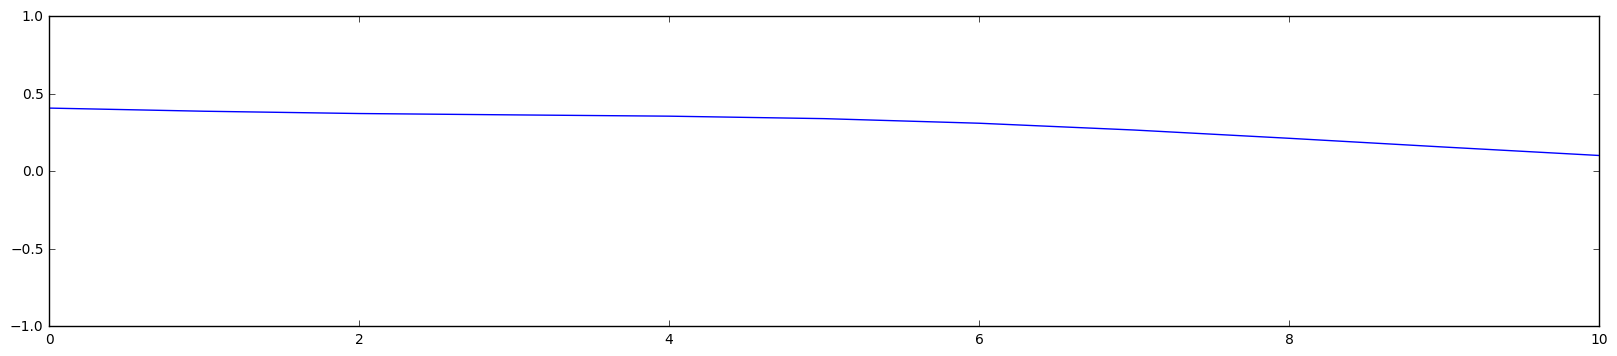

In [6]:
plt.figure(figsize=(20,4))
# 
# Используйте pylab.plot для построения графика, нарисуйте y, sr
pylab.plot(y)
#
pylab.xlim([0, 10])
pylab.show()

# Sound as 2D-Signal

Нашу цель слелать из предыдущего графика картинку - для этого нам нужно оценить частоты в каждый момент времени. Благо за нас это умеет делать librosa, у которой внутри STFFT. Используйте librosa.feature.melspectrogram -- для получения спектрограммы, и librosa.logamplitude для выравнивания диапазонов частот. 

help: https://gist.github.com/mailletf/3484932dd29d62b36092

In [7]:
S = librosa.feature.melspectrogram(y)
log_S = librosa.logamplitude(S)

Нарисуйте спектрограмму, получилась красивая картинка?

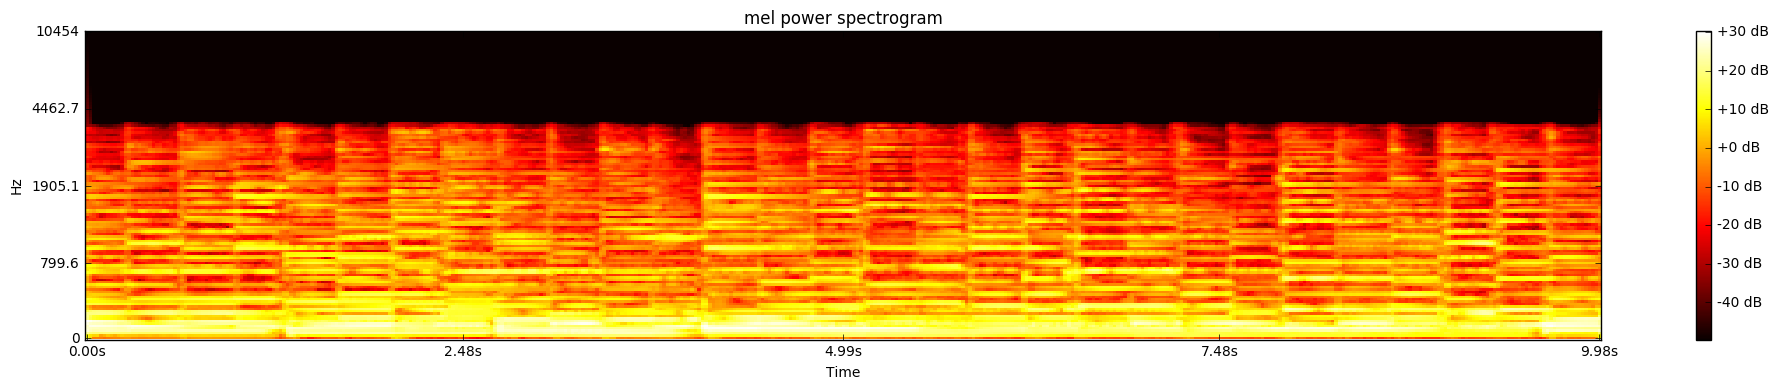

In [8]:
plt.figure(figsize=(20,4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel', cmap='hot')
plt.title('mel power spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

# Prepare the Data

В этой секции мы создадим датасет, прочитав все данные.

In [3]:
def get_path(i=1):
    return os.path.join(BP, 'spectrograms', 'spectrograms{}.pcl'.format(i))

In [4]:
num_chunks = 6

In [5]:
import numpy as np
X = np.concatenate([np.load(get_path(i), mmap_mode='r') for i in range(1, num_chunks + 1)])

Здесь вы должны получить train genres. Они идут подряд в соответствии с последовательностью треков в файлах с данными. Для содержимого первых шести файлов у вас есть жанры, а для последнего файла, вам их нужно предсказать.

In [46]:
with open(os.path.join(BP, "train_genres.txt"), "rt") as f_in:
    train_genres = numpy.array(map(lambda x: x.strip(), f_in.readlines())[:2000*num_chunks])

In [47]:
genres = set(train_genres)

In [48]:
num_classes = len(set(genres))

In [50]:
le = LabelEncoder()
inverse_transform = le.inverse_transform

In [51]:
train_genres = le.fit_transform(train_genres)

# Nearest Neighbors genre classification

Let's try to solve similarity task by the nearest neighbour approach.

<img src="./img/nn.png" width="300">

Перемешаем датасет - используйте `np.random.permutation` и индексацию `a[np.random.permutation]`.

In [9]:
perm = np.random.permutation(len(train_genres))
X, y = X[perm], train_genres[perm]

Разобьем датасет на трейн и валидацию 80/20%.

In [10]:
def split_data():
    return train_test_split(X, y, train_size=0.8, test_size=0.2)

In [11]:
X_train, X_valid, y_train, y_valid = split_data()

In [12]:
X_train.shape

(9600, 128, 431)

In [13]:
X.shape[0]

12000

Попробуем поклассифицировать жанры методом ближайших соседей.

In [25]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
clf = clf.fit(X_train.reshape(X_train.shape[0], X.shape[1]*X.shape[2]), y_train)
y_val_pred = clf.predict(X_valid.reshape(X_valid.shape[0], X.shape[1]*X.shape[2]))

print accuracy_score(y_valid, y_val_pred)

0.06


![0.1375](http://images.christianpost.com/full/53197/solving-work-conflicts-e-mail-doesnt-work.jpg)

# Fully-Connected Neural Nets

Использовать нейросети - это хорошая идея, давайте начнем с полносвязных сетей.

In [16]:
import theano
import lasagne
import theano.tensor as T

from utils import train_net

Перемешаем и разобьем датасет.

In [19]:
perm = np.random.permutation(len(train_genres))
X, y = np.array(X)[perm].astype('float32'), np.array(train_genres)[perm]
num_classes = len(set(genres))

X_train, X_valid, y_train, y_valid = split_data()
#X_train, X_valid = Xreshape[:10000], Xreshape[10000:]
#y_train, y_valid = ta[:10000], y[10000:]

In [17]:
X.shape

(12000, 128, 431)

In [18]:
from lasagne import nonlinearities
from lasagne import layers
from lasagne import init

In [26]:
input_X, target_y = T.tensor4("X", dtype='float32'), T.vector("y", dtype='int32')
l_in = lasagne.layers.InputLayer(shape=(None, 1, X.shape[1], X.shape[2]), input_var=input_X, name='input layer') 

dl1 = lasagne.layers.DenseLayer(l_in, num_units=2048, nonlinearity=nonlinearities.rectify,
                                W=init.GlorotNormal(), name='fully connected 1')

dl2 = lasagne.layers.DenseLayer(dl1, num_units=1024, nonlinearity=nonlinearities.rectify,
                                W=init.GlorotNormal(), name='fully connected 2')
#
# Используйте 2-3 больших полносвязных слоя, обучилась ли сеть? если нет то почему?
#

nn = layers.DenseLayer(dl2, num_units=num_classes, nonlinearity=nonlinearities.softmax, 
                      name = 'output layer')

y_predicted = lasagne.layers.get_output(nn)
all_weights = lasagne.layers.get_all_params(nn)

loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()
updates_sgd = lasagne.updates.nesterov_momentum(loss, all_weights,learning_rate=0.01, momentum=0.9)

In [27]:
train_fun = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True, updates=updates_sgd)
test_fun  = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True)

In [19]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((9600, 128, 431), (9600,), (2400, 128, 431), (2400,))

In [57]:
from utils import iterate_minibatches

In [47]:
%time conv_nn = train_net(nn, train_fun, test_fun, X_train, y_train, X_valid, y_valid, num_epochs=10, batch_size=50)

Epoch   1 of  10 train_loss = nan val_loss = nan train_acc = 3.25 val_acc = 4.75
Epoch   2 of  10 train_loss = nan val_loss = nan train_acc = 3.25 val_acc = 4.75
Epoch   3 of  10 train_loss = nan val_loss = nan train_acc = 3.25 val_acc = 4.75
Epoch   4 of  10 train_loss = nan val_loss = nan train_acc = 3.25 val_acc = 4.75
Epoch   5 of  10 train_loss = nan val_loss = nan train_acc = 3.25 val_acc = 4.75
Epoch   6 of  10 train_loss = nan val_loss = nan train_acc = 3.25 val_acc = 4.75
Epoch   7 of  10 train_loss = nan val_loss = nan train_acc = 3.25 val_acc = 4.75
Epoch   8 of  10 train_loss = nan val_loss = nan train_acc = 3.25 val_acc = 4.75
Epoch   9 of  10 train_loss = nan val_loss = nan train_acc = 3.25 val_acc = 4.75
Epoch  10 of  10 train_loss = nan val_loss = nan train_acc = 3.25 val_acc = 4.75
CPU times: user 29min 12s, sys: 8min 43s, total: 37min 56s
Wall time: 14min 39s


![yeah](http://www.memecreator.org/static/images/memes/2669224.jpg)

# Convolution Neural Nets

Да, вероятно, полносвязные сети не зажгли и kNN не обогнали. Давайте попробуем сверточные, хороший вариант делать одномерные свертки (сразу по всем частотам). Хотя двумерные тоже могут работать. 

Архитектуру можно подсмотреть [тут](http://benanne.github.io/2014/08/05/spotify-cnns.html).

In [20]:
import theano
import lasagne
import theano.tensor as T
from lasagne.regularization import regularize_layer_params, regularize_network_params, l2

from utils import train_net

In [21]:
perm = np.random.permutation(len(y))
X, y = np.array(X)[perm].astype('float32'), np.array(y)[perm]

X_train, X_valid, y_train, y_valid = split_data()
# X_train, X_valid = Xreshape[:10000], Xreshape[10000:]
# y_train, y_valid = y[:10000], y[10000:]

In [22]:
input_X, target_y = T.tensor3("X", dtype='float32'), T.vector("y", dtype='int32')
#nn = ??? Сделайте свою сеть, используя: Conv1DLayer + MaxPool1DLayer + DenseLayer

nn = {}

nn['input'] = layers.InputLayer(shape=(None, X.shape[1], X.shape[2]), input_var=input_X)
nn['conv1'] = layers.Conv1DLayer(nn['input'], num_filters=128, filter_size=4, stride=1)
nn['pool1'] = layers.MaxPool1DLayer(nn['conv1'], pool_size=4, stride=1)
nn['conv2'] = layers.Conv1DLayer(nn['pool1'], num_filters=256, filter_size=4, stride=1)
nn['pool2'] = layers.MaxPool1DLayer(nn['conv2'], pool_size=2, stride=1)
nn['conv3'] = layers.Conv1DLayer(nn['pool2'], num_filters=256, filter_size=4, stride=1)
nn['pool3'] = layers.MaxPool1DLayer(nn['conv3'], pool_size=2, stride=1)
nn['conv4'] = layers.Conv1DLayer(nn['pool3'], num_filters=512, filter_size=4, stride=1)
nn['pool4'] = layers.MaxPool1DLayer(nn['conv4'], pool_size=2, stride=1)


#fully-connected layers

nn['globalpooling'] = layers.GlobalPoolLayer(nn['pool4'])



nn['fc1'] = layers.DenseLayer(nn['globalpooling'], num_units=2048,
                              nonlinearity=nonlinearities.rectify,
                             W = init.Orthogonal('relu'))

nn['drop1'] = layers.DropoutLayer(nn['fc1'], p=0.5)

nn['fc2'] = layers.DenseLayer(nn['drop1'], num_units=2048, 
                              nonlinearity=nonlinearities.rectify,
                             W = init.Orthogonal('relu'))

nn['drop2'] = layers.DropoutLayer(nn['fc2'], p=0.5)

nn['output'] = layers.DenseLayer(nn['drop2'], num_units=num_classes,                                 
                                 nonlinearity=nonlinearities.softmax)

network = nn['output'] 

In [23]:
y_predicted = lasagne.layers.get_output(network)
all_weights = lasagne.layers.get_all_params(network)

loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()
loss += regularize_layer_params(nn['fc1'], l2) * 0.01
loss += regularize_layer_params(nn['fc2'], l2) * 0.01

accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()
updates_sgd = lasagne.updates.adam(loss, all_weights)

In [24]:
train_fun = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True, updates=updates_sgd)
test_fun  = theano.function([input_X, target_y], [loss, accuracy], allow_input_downcast=True)

In [26]:
from collections import Counter

In [27]:
Counter(y_train)

Counter({0: 1,
         1: 367,
         3: 6,
         4: 2,
         5: 14,
         6: 27,
         7: 10,
         8: 1,
         9: 27,
         10: 85,
         11: 8,
         12: 19,
         13: 499,
         14: 16,
         15: 13,
         17: 10,
         18: 31,
         19: 634,
         20: 408,
         21: 18,
         22: 5,
         23: 171,
         24: 7,
         25: 5,
         26: 19,
         27: 73,
         28: 53,
         29: 5,
         30: 100,
         31: 1,
         32: 36,
         33: 17,
         34: 5,
         35: 161,
         36: 5,
         37: 4,
         38: 14,
         39: 2,
         40: 102,
         41: 3362,
         42: 14,
         43: 81,
         44: 559,
         45: 27,
         46: 4,
         47: 77,
         48: 132,
         49: 7,
         50: 954,
         51: 16,
         52: 294,
         53: 336,
         54: 344,
         55: 3,
         56: 27,
         57: 240,
         58: 9,
         59: 7,
         60: 2,
         

In [28]:
Counter(y_valid)

Counter({0: 1,
         1: 78,
         2: 1,
         3: 1,
         5: 4,
         6: 7,
         7: 4,
         9: 12,
         10: 21,
         11: 4,
         12: 3,
         13: 102,
         14: 3,
         15: 2,
         16: 1,
         17: 5,
         18: 3,
         19: 138,
         20: 98,
         21: 8,
         23: 49,
         24: 2,
         25: 2,
         26: 1,
         27: 19,
         28: 19,
         29: 1,
         30: 24,
         31: 1,
         32: 7,
         33: 3,
         34: 1,
         35: 41,
         36: 2,
         38: 2,
         40: 30,
         41: 842,
         43: 31,
         44: 158,
         45: 10,
         46: 2,
         47: 17,
         48: 26,
         49: 2,
         50: 244,
         51: 2,
         52: 73,
         53: 91,
         54: 84,
         55: 1,
         56: 9,
         57: 61,
         58: 4,
         59: 1,
         61: 2,
         62: 2,
         63: 19,
         64: 14,
         65: 1,
         66: 4})

#Подумайте, какой размер батча нужен и сколько эпох вы можете себе позволить подождать
print 'started training'
%time conv_nn = train_net(network, train_fun, test_fun, X_train, y_train, X_valid, y_valid, num_epochs=175, batch_size=300)

In [77]:
params = np.load('./epoch_time_valacc 150:2016-10-20 14:37:36.816583:43.125.npy')
p = map(lambda x: x.get_value(), params)
layers.set_all_param_values(network, p)
predict = theano.function([input_X], T.argmax(lasagne.layers.get_output(network, deterministic=True), axis=1))

In [78]:
to_pred = np.load('./musicdata/spectrograms/spectrograms7.pcl')
final_prediction = inverse_transform(predict(to_pred.astype('float32')))

In [79]:
Counter(final_prediction)

Counter({'alternative': 3,
         'dance': 29,
         'electronics': 62,
         'metal': 20,
         'other': 1,
         'pop': 1333,
         'rap': 179,
         'rock': 228,
         'rusrap': 14,
         'rusrock': 43,
         'shanson': 70,
         'soundtrack': 17,
         'trance': 1})

In [87]:
import pandas as pd

In [ ]:
pd.Dataframe( )

Давайте нарисуем каждый второй фильтр - можете ли вы проинтерпретировать эти фильтры?

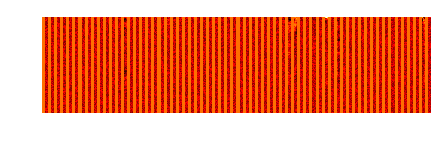

In [80]:
plt.figure(figsize=(5, 5), dpi=500)
W = lasagne.layers.get_all_params(network)[0].get_value()
W[::2, :, :] = 0.2
W = np.hstack(W)
pylab.imshow(W, cmap='hot', interpolation="nearest")
pylab.axis('off')
pylab.show()

# Maps of tracks by SVD and tSNE

Хорошая идея посмотреть, как полученое представление отображается с сохранением относительных расстояний на плоскость. Используйте tSNE или PCA.

Help: https://lts2.epfl.ch/blog/perekres/category/visualizing-hidden-structures-in-datasets-using-deep-learning/

In [82]:
from sklearn.manifold import TSNE

In [83]:
represent = lasagne.layers.get_output(network.input_layer)
represent_fun = theano.function([input_X], [represent], allow_input_downcast=True)

In [84]:
f = lambda x: np.array(represent_fun([x])[0])
track_vectors = map(f, X_train) + map(f, X_valid)
track_vectors = np.concatenate(track_vectors, axis=0)

track_labels = np.array(list(y_train) + list(y_valid))

получите 2d вектора

In [86]:
X_tsne = TSNE().fit_transform(track_vectors)

нарисуйте получившиеся точки

In [99]:
id2gener = dict(zip(range(0, 67), map(inverse_transform, range(0, 67))))

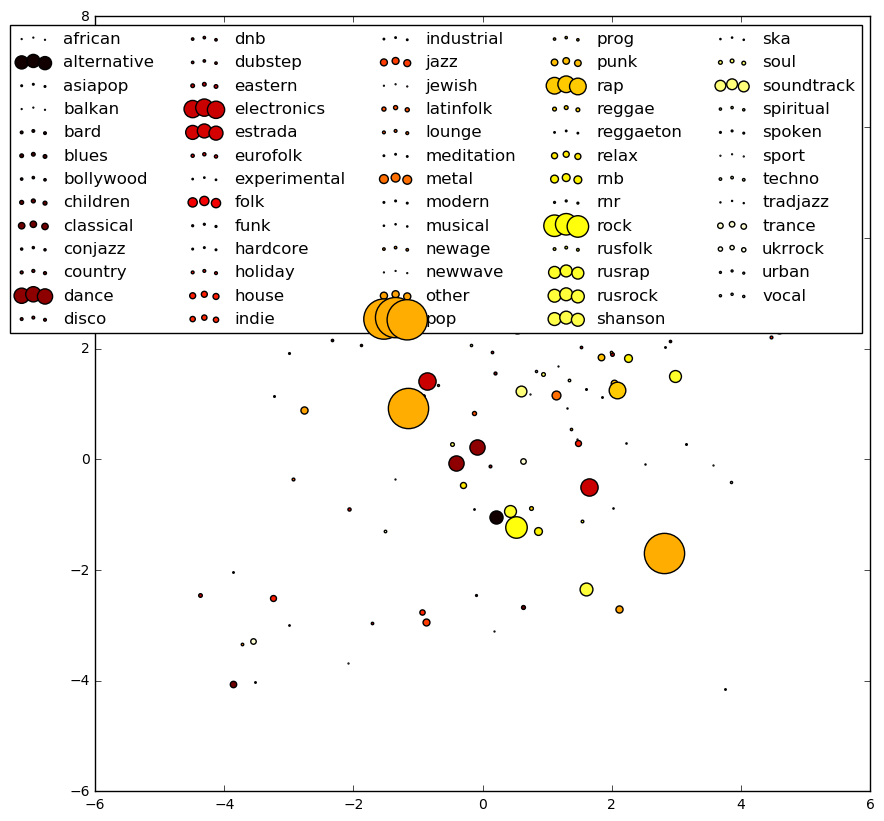

In [120]:
plt.figure(figsize=(10,10), dpi=500)
colors = cm.hot(np.linspace(0, 1, len(id2gener)))

for idx, gener in id2gener.items():
    idx_ = np.where(track_labels == idx)
    if size(idx_) >= 2:
        pylab.scatter(X_tsne[idx_][0], X_tsne[idx_][1], c=colors[idx], cmap=cm.hot,
                      label=gener,s=0.2*len(X_tsne[idx_]))

pylab.legend(loc=0, ncol=5)

![finally](https://i.ytimg.com/vi/fGl4LOAgW50/maxresdefault.jpg)